# Dataset

This notebook contains the steps for data preparation. It must be mentioned that to run this notebook, the Yelp dataset should be donloaded in you personal computer and then you can run the notebook locally.

Yelp dataset can be found here: https://www.yelp.com/dataset

The notebooks taken in reference for this first process is https://github.com/Sonull/Sentiment-Analysis-on-Yelp-Reviews and https://michael-fuchs-python.netlify.app/2021/06/16/nlp-text-pre-processing-vi-word-removal/ 

In [2]:
#pip install -U gensim

In [143]:
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preparation

**Business Category**

In [4]:
business_df = pd.read_json('../Dataset/yelp_academic_dataset_business.json', lines = True)

business_df.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [5]:
#how many different categories do we have
len(business_df.categories.unique())

88116

**Reviews**

In [6]:
#read reviews from json file
reviews = pd.read_json('../Dataset/yelp_academic_dataset_review.json',lines = True,chunksize=50000)
for r in reviews:
    review_subset = r
    break

In [7]:
review_subset.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [8]:
#merge reviews with business category. Business category will be important for human evaluation 
categories_id = business_df[['business_id','categories']]
reviews = review_subset.merge(categories_id, how='left', on='business_id')
reviews.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,categories
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."


In [9]:
business_df = pd.read_json('../Dataset/yelp_academic_dataset_business.json', lines = True)

#### Converting reviews to positive and negative only + balancing the dataset

In [10]:
df_reviews = reviews
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    50000 non-null  object        
 1   user_id      50000 non-null  object        
 2   business_id  50000 non-null  object        
 3   stars        50000 non-null  int64         
 4   useful       50000 non-null  int64         
 5   funny        50000 non-null  int64         
 6   cool         50000 non-null  int64         
 7   text         50000 non-null  object        
 8   date         50000 non-null  datetime64[ns]
 9   categories   49996 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 4.2+ MB


In [11]:
#drop columns we do not need
df_reviews = df_reviews.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'date'], axis = 1)

In [12]:
# dropping reviews with 3 stars because they are neutral and do not shows too much
df_reviews.drop(df_reviews.index[df_reviews['stars'] == 3], inplace = True)
df_reviews.shape

(43985, 3)

In [13]:
# changing to only 2 labels: if 1 or 2 starts then:negative, if 4 or 5 stars then:positive and delete stars column
df_reviews['rate'] = df_reviews['stars'].replace({1:0, 2:0, 4:1, 5:1})
df_reviews = df_reviews.drop(['stars'], axis = 1)
df_reviews.head(5)

,text,categories,rate
0,Apparently Prides Osteria had a rough summer a...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",1
1,This store is pretty good. Not as great as Wal...,"Department Stores, Optometrists, Home & Garden...",1
2,I called WVM on the recommendation of a couple...,"Home Services, Packing Services, Movers",1
3,I've stayed at many Marriott and Renaissance M...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",0
4,The food is always great here. The service fro...,"Restaurants, French",1


In [14]:
#drop null
df_reviews.dropna(inplace=True)

In [15]:
df_reviews['rate'].value_counts()

1    33769
0    10212
Name: rate, dtype: int64

In [16]:
#checking the length of each review
df_reviews['length'] = df_reviews['text'].apply(lambda x : len(x.strip().split(" ")))
df_reviews['length'].describe()

count    43981.00000
mean       105.75353
std         98.58637
min          1.00000
25%         43.00000
50%         76.00000
75%        134.00000
max       1242.00000
Name: length, dtype: float64

In [17]:
#checking the 95% quantile from all the sample
np.quantile(df_reviews['length'], 0.95)  #we should use this as max length

292.0

In [18]:
# checking the reviews with very small lengths
df_reviews[['text', 'length']][df_reviews['length']<=3].sort_values(by='length')

,text,length
7213,いつもLAからラスベガスに行く途中のお楽しみが、オースティンにあった！！生のポテトを使ったフ...,1
9094,朋友生日时去吃的，提前订了位置和烤鸭。\n餐馆依水，景致不错。\n在我看来只要不是特别惊艳或...,1
16307,這是一間現已為數不多仍然是推車仔賣奌心的茶樓，真系好鬼懐舊，我朋友叫左虾餃，燒賣同埋魚蓉腸粉...,1
22383,CLOSED!!\nhttp://www.boston.com/lifestyle/food...,1
26207,キーンの横にあるコーヒー屋さん。ショッピングに疲れた時の休憩にぴったり。コーヒーは苦めで美味...,1
26253,很失望，广告发了很多但是东西都不入味，感觉不像炒的，是不是东西就煮了一下然后倒点酱汁上去就完...,1
30706,虾、蟹腿等海鲜都不够入味，应该就是白水煮过之类的又浇上酱而已，玉米、香肠等还可以。另外服务人...,1
46821,服务员太阴阳怪气\n荤菜和素菜都太难吃了\n都是美国式的中国菜\n服务员太阴阳怪气\n荤菜和...,1
48776,我今天带着一家人去吃饭，也是第一次去那边，因为是武汉人，别人推荐那边有不错的热干面和各种卤味...,1
7396,蠻特別的地方\n結合BAR和保齡球\n氣氛非常好\n就算沒有要打 也可以玩得很開心\n有酒喝...,3


In [19]:
df_reviews = df_reviews.loc[df_reviews["length"] != 0]
df_reviews = df_reviews.loc[df_reviews["length"] != 1]
df_reviews = df_reviews.loc[df_reviews["length"] != 2]
df_reviews = df_reviews.loc[df_reviews["length"] != 3]
df_reviews

,text,categories,rate,length
0,Apparently Prides Osteria had a rough summer a...,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",1,322
1,This store is pretty good. Not as great as Wal...,"Department Stores, Optometrists, Home & Garden...",1,123
2,I called WVM on the recommendation of a couple...,"Home Services, Packing Services, Movers",1,112
3,I've stayed at many Marriott and Renaissance M...,"Hotels, Hotels & Travel, Restaurants, Event Pl...",0,71
4,The food is always great here. The service fro...,"Restaurants, French",1,36
...,...,...,...,...
49995,My first appointment was with Mandy Denson and...,"Hair Salons, Beauty & Spas",1,78
49996,I am very happy we chose to have dinner at Fly...,"American (New), Seafood, Cocktail Bars, Restau...",1,76
49997,"Again, we used our library pass to see this mu...","Shopping, Art Museums, Art Galleries, Arts & E...",1,61
49998,We've been here several time both with and wit...,"Restaurants, American (New), Ramen, Izakaya, J...",1,108


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rate', ylabel='count'>

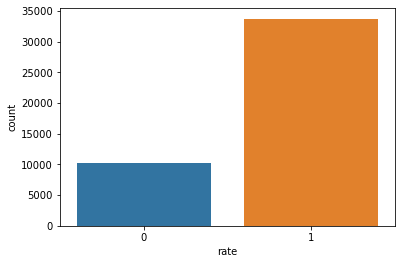

In [20]:
sns.countplot(df_reviews['rate'])  

In [21]:
#balancing the dataset

nr_neg = df_reviews[df_reviews['rate']==0].shape[0]
nr_pos = df_reviews[df_reviews['rate']==1].shape[0]

if nr_pos>nr_neg:
    df_reviews = df_reviews.sort_values('rate').head(2*nr_neg)
else:
    df_reviews = df_reviews.sort_values('rate').tail(2*nr_pos)
    


In [22]:
df_reviews['rate'].value_counts()    

0    10207
1    10207
Name: rate, dtype: int64

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rate', ylabel='count'>

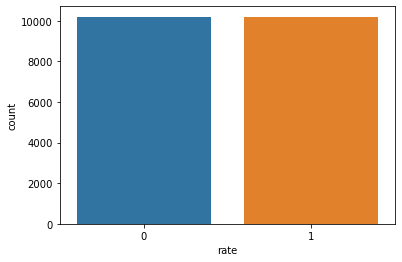

In [23]:
sns.countplot(df_reviews['rate'])

## Data Preproccesing

In [24]:
#word 'not' should not be removed from the dataset as it drastically changes the classification class
STOPWORDS
s = ({'not'})
new_stopwords = STOPWORDS.difference(s)

In [25]:
for r in df_reviews:
    df_reviews['clean_review'] = df_reviews['text'].apply(lambda t: re.sub(r"https?://[A-Za-z0-9./]+", ' ', t))
    df_reviews['clean_review'] = df_reviews['clean_review'].apply(lambda t: re.sub(r"[^a-zA-Z]", ' ', t))
    df_reviews['clean_review'] = df_reviews['clean_review'].apply(lambda t: strip_multiple_whitespaces(t))
    df_reviews['clean_review'] = df_reviews['clean_review'].apply(lambda t: t.lower())
    df_reviews['clean_review'] = df_reviews['clean_review'].apply(lambda t: remove_stopwords(t, new_stopwords))
    df_reviews['clean_review'] = df_reviews['clean_review'].apply(lambda t: strip_short(t))    

In [26]:
df_reviews['clean_review']

49999    times lunch best food tried breakfast meals ri...
41887    lazy incompetent sales person richard jenkins ...
33162    goes review honestly unhappy decision coming f...
22140    jiffy lubes austin far worst toyota camry uses...
22138    nice wine food poor service waited mins host f...
                               ...                        
38580    coffee machine issue months purchase clive sen...
38582    awesome great place eat breakfast service quic...
38583    best tacos east location small think twice rec...
38584    love place relaxing spa like atmosphere damn g...
38585    patient jamin years lot muscle tension shoulde...
Name: clean_review, Length: 20414, dtype: object

In [27]:
#the new column shoul be converted to string
df_reviews['clean_review'] = df_reviews['clean_review'].astype(str)

In [28]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20414 entries, 49999 to 38585
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          20414 non-null  object
 1   categories    20414 non-null  object
 2   rate          20414 non-null  int64 
 3   length        20414 non-null  int64 
 4   clean_review  20414 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


In [29]:
#checking the length of each review
df_reviews['length_clean_review'] = df_reviews['clean_review'].astype(str).apply(lambda x : len(x.strip().split(" ")))
df_reviews['length_clean_review'].describe()

count    20414.000000
mean        48.592241
std         43.828796
min          1.000000
25%         21.000000
50%         35.000000
75%         61.000000
max        441.000000
Name: length_clean_review, dtype: float64

<Figure size 1800x7200 with 0 Axes>

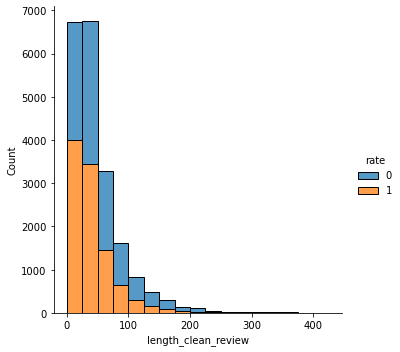

In [30]:
plt.figure(figsize=(25, 100))
plot = sns.displot(data=df_reviews, x='length_clean_review', hue='rate', multiple='stack', bins=np.arange(0,450,25))

In [31]:
df_reviews.to_csv('../Dataset/all_reviews.csv')

In [32]:
X = df_reviews.drop(['rate'], axis = 1)
y = df_reviews['rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X_train.to_csv('../Dataset/X_train_all.csv')
X_test.to_csv('../Dataset/X_test_all.csv')
y_train.to_csv('../Dataset/y_train_all.csv')
y_test.to_csv('../Dataset/y_test_all.csv')

In [34]:
df_reviews.head(10)

,text,categories,rate,length,clean_review,length_clean_review
49999,Been here several times for lunch. The best f...,"Cajun/Creole, Restaurants, Breakfast & Brunch,...",0,79,times lunch best food tried breakfast meals ri...,40
41887,Lazy and incompetent sales person. Richard Je...,"Automotive, Car Dealers, Auto Repair, Auto Par...",0,191,lazy incompetent sales person richard jenkins ...,73
33162,So here it goes my first review. I honestly wa...,"American (New), Nightlife, American (Tradition...",0,152,goes review honestly unhappy decision coming f...,57
22140,I've been to several Jiffy Lubes around Austin...,"Automotive, Oil Change Stations, Windshield In...",0,246,jiffy lubes austin far worst toyota camry uses...,101
22138,"nice wine, so-so food, poor service. \n\nWai...","Restaurants, French",0,173,nice wine food poor service waited mins host f...,69
41879,You may think the long lines are an indicator ...,"Food Stands, Food, Coffee & Tea, Chocolatiers ...",0,273,think long lines indicator high demand great f...,131
10665,This gym has a great set up but the lack of ai...,"Leisure Centers, Climbing, Fitness & Instructi...",0,45,gym great set lack airconditioning summer brut...,15
33169,The worst strip show ever! Guys were not attra...,"Event Planning & Services, Arts & Entertainmen...",0,53,worst strip guys not attractive horrible start...,24
10670,I love this Whole Foods because it is the pers...,"Food, Hotels & Travel, Health Markets, Grocery...",0,38,love foods personification life boston bitter ...,17
10671,I was happy to see a new restaurant open up in...,"Italian, Pizza, Restaurants, Cocktail Bars, Ni...",0,147,happy new restaurant open east andrews finally...,59


### Other Transformations 

#### Check number of unique words

In [131]:
all_words = df_reviews.clean_review.tolist() #astype(str)
word_string = ' '.join(all_words)

In [132]:
len(set(word_string.split())) #number of unique words 

35027

In [133]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [134]:
w = word_count(word_string)

In [135]:
data_items = w.items()
data_list = list(data_items)
df = pd.DataFrame(data_list, columns = ['Word', 'Frequency'])
df.sort_values(by="Frequency", ascending=False)[:10]

,Word,Frequency
2,not,16278
65,food,11337
15,place,9915
18,good,9178
285,like,7575
50,service,7464
126,time,7256
377,great,7198
139,got,4360
166,order,3829


In [155]:
#df_freq_1 = df[df['Frequency'] ==1]
df_freq_1

,Word,Frequency
12,frathouse,1
69,laffa,1
182,diffrent,1
186,shebwas,1
217,thet,1
...,...,...
35021,barcelos,1
35023,cringing,1
35024,musicmknmarvel,1
35025,machin,1


From the most common words, we cannot delete them because some of them are important for the context of the sentence, but the words that are used only once, look more like typos, so we remove them from the senteces.

In [140]:
def multiple_word_remove_func(text, words_2_remove_list):
 
    words_to_remove_list = words_2_remove_list
    
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in words_to_remove_list])
    return text

In [156]:
words_2_remove_list = df_freq_1['Word'].tolist()
#checking the length of each review
df_reviews['clean_review'] = df_reviews['clean_review'].astype(str).apply(lambda x : multiple_word_remove_func(x, words_2_remove_list))

In [157]:
X_train['clean_review'] = X_train['clean_review'].astype(str).apply(lambda x : multiple_word_remove_func(x, words_2_remove_list))
X_test['clean_review'] = X_test['clean_review'].astype(str).apply(lambda x : multiple_word_remove_func(x, words_2_remove_list))

#### Convert and save data as pad_sequences

In [ ]:
#padding sequences
train_sentences = X_train.clean_review
test_sentences = X_test.clean_review
all_sentences = df_reviews.clean_review

In [160]:
#word index dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_sentences)
word_index = tokenizer.word_index

In [161]:
len(word_index)

20646

In [162]:
with open('../saved_data/word_index', 'wb') as f:
    pickle.dump(word_index, f)

In [163]:
max_length = 50

#train dataset
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post")

#test dataset
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post")

In [165]:
with open('../saved_data/train_padded', 'wb') as f:
    pickle.dump(train_padded, f)
    
with open('../saved_data/test_padded', 'wb') as f:
    pickle.dump(test_padded, f)    